In [1]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

DATA_PATH = "./data/pet_store_records_2020.csv"

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_12466/2475712656.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet = datasheet.drop([
    'vendor_id', 
    'VAP', 
    'country', 
    'pet_size'
], axis=1)
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,Equipment,123,7293,fish,7,1
4567,Toys,61,9304,cat,10,0
4237,Toys,218,8180,hamster,6,0
4364,Snack,69,18559,dog,1,1
4184,Supplements,138,10283,dog,10,0


### Plotting for analysis

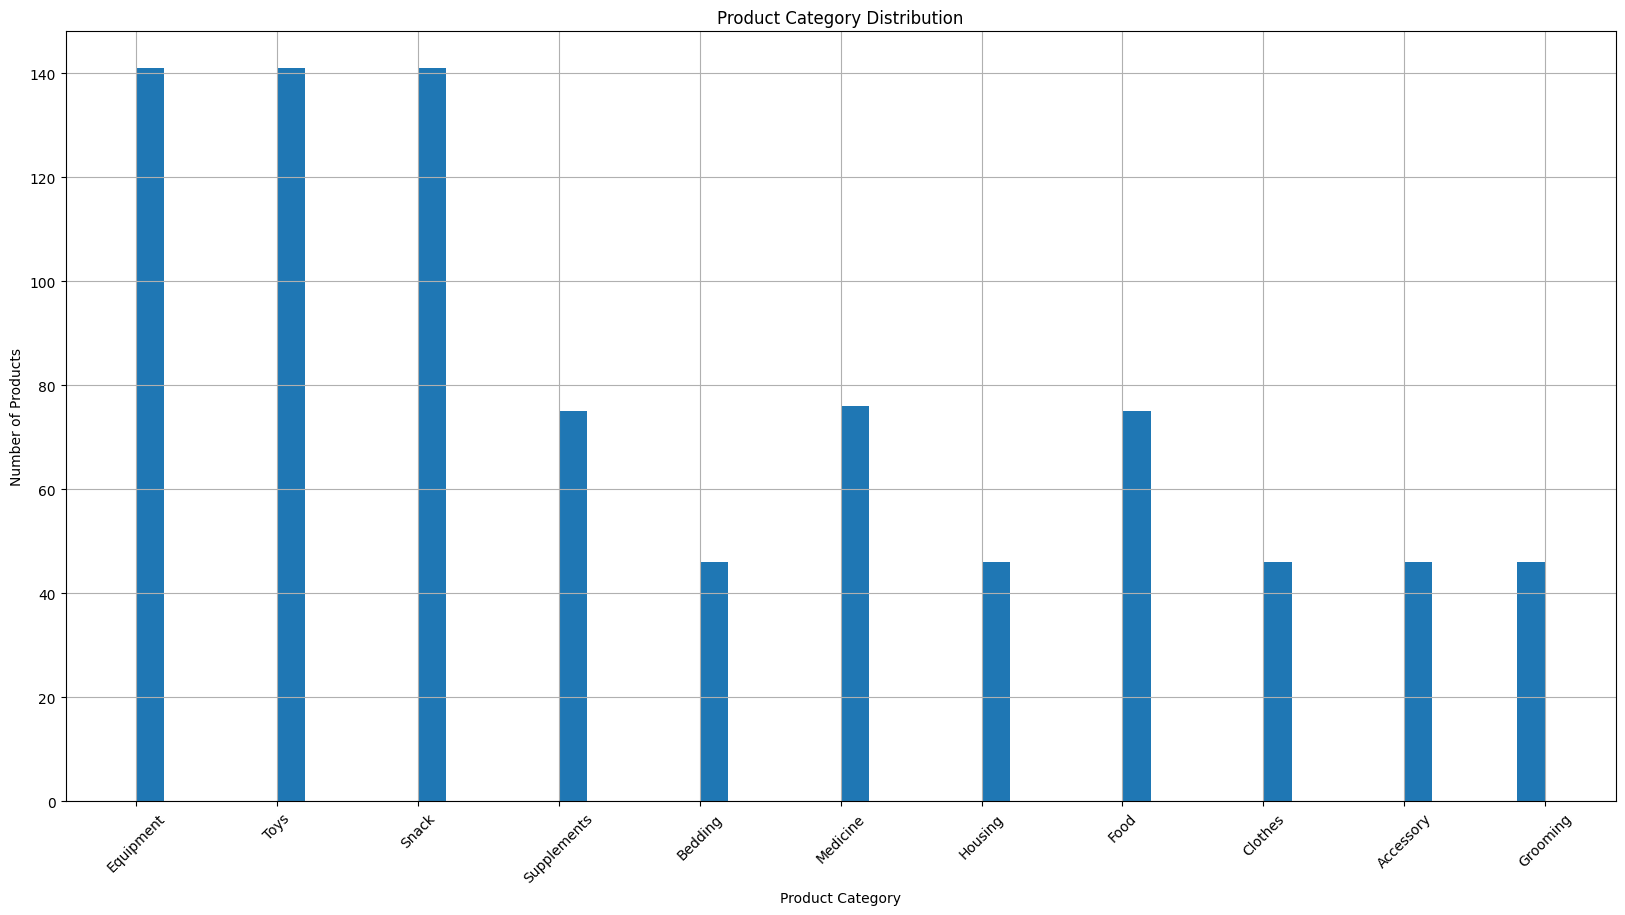

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

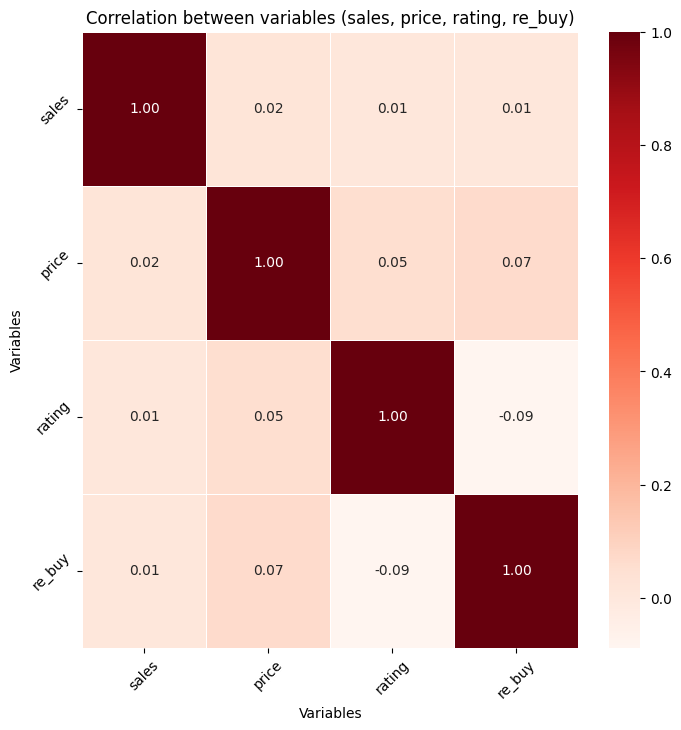

In [5]:
relationship = datasheet[["sales", "price", "rating", "re_buy"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(relationship, annot=True, fmt=".2f", linewidths=.5, cmap='Reds')
plt.title("Correlation between variables (sales, price, rating, re_buy)")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.yticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.show()

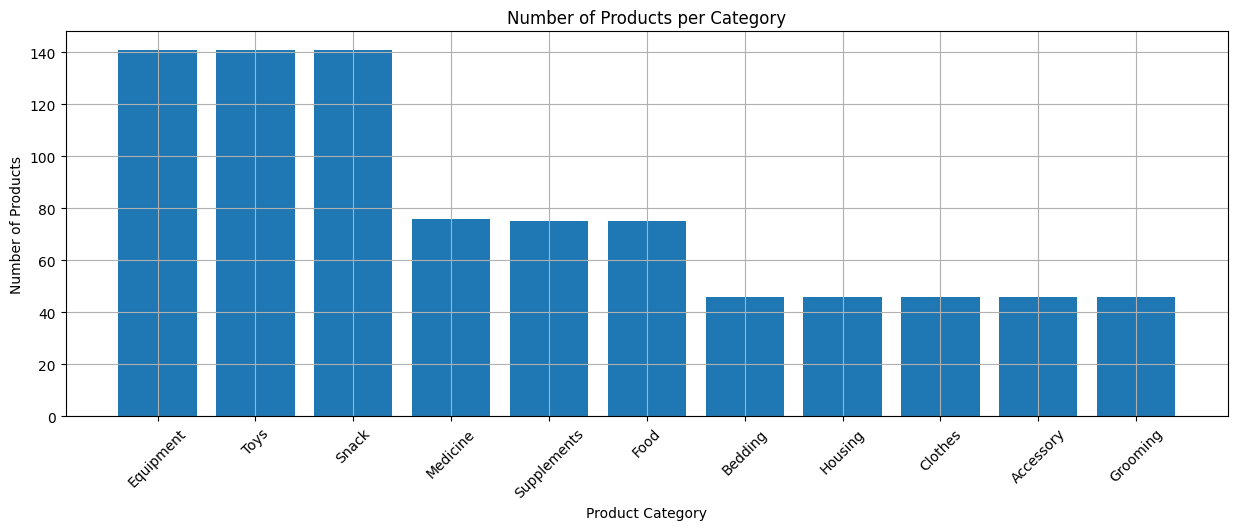

In [6]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

In [7]:
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,Equipment,123,7293,fish,7,1
4567,Toys,61,9304,cat,10,0
4237,Toys,218,8180,hamster,6,0
4364,Snack,69,18559,dog,1,1
4184,Supplements,138,10283,dog,10,0


# Pre-processing

In [8]:
onehot_encoder = OneHotEncoder()

In [9]:
transformed_target = datasheet['pet_type'].values.reshape(-1, 1)
transformed_target_unique = np.unique(transformed_target)

le = LabelEncoder()
transformed_target = le.fit_transform(transformed_target.ravel())

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"le_name_mapping: {le_name_mapping}")

datasheet['pet_type'] = transformed_target

le_name_mapping: {'bird': 0, 'cat': 1, 'dog': 2, 'fish': 3, 'hamster': 4, 'rabbit': 5}


In [10]:
le = LabelEncoder()
product_category = datasheet['product_category'].to_numpy()
product_category_onehot = le.fit_transform(product_category.reshape(-1, 1)).astype(int)

print(f"One-hot encoded product category: {product_category_onehot}")

# softmax_dim = product_category_onehot.shape[1]
# print(f"Softmax dimension: {softmax_dim}")

One-hot encoded product category: [ 3 10 10  8  9  1 10  1  9  7  8  9  6  4  9  3  8  3  4  4  6  2  0  4
  7  3  0  4  6  9  7  3  8  2  8  7  0 10  1  3  8  1  0  4  4  8  5  8
 10  3  5  2  2  4  3 10  3 10  2  8  3  6  2  3  3  6  9  6  7  9  6 10
  5  1  5  0 10  7  3 10  4  0 10  6  8  9  9  1  2  3  6  8  5  8  9  2
  7  2  3 10 10  0  3  3 10 10  7  9  4 10  3  3  2  8  1  2  7  3  0  4
  6  4  7  8  3  8  3 10  8  7  4  3  7  5  8  8 10  8  7  4  6  3  8 10
 10  5 10  8 10  6 10  8  2  5  9  8  8  1  3  3  5  7  7  6 10 10  7  8
 10  3  8  8  8 10 10  3  4  3  8  9  2  9  3  8  8  7  9  2 10  7  4  8
  5  0  9  4  7 10  2  9 10  3 10  5 10  3  8 10 10  8 10 10  6  5  9  5
  2  7  2  8  1 10  0  3  5  7  8  9  3  1  9  3  9  7  3  0  3  1  4  3
  8  6  4  8 10  4  8 10  3  0  4  8  9  6  5  8  3  8 10  4 10 10  3  3
  3  8  4  7  7  4  3  1 10  2  3 10  8  9 10  3  8  0 10  8  3  9  7  5
  0  8  6  9  0  7  8  4 10  8  9  2  7  6  8  9  0  5  3 10  2  1  9  4
 10  7  0  9  1  

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
for i in range(len(datasheet.index)): datasheet['product_category'].iloc[i] = product_category_onehot[i]
datasheet.head(10)

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_12466/1629457035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i in range(len(datasheet.index)): datasheet['product_category'].iloc[i] = product_category_onehot[i]


,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,3,123,7293,3,7,1
4567,10,61,9304,1,10,0
4237,10,218,8180,4,6,0
4364,8,69,18559,2,1,1
4184,9,138,10283,2,10,0
4609,1,183,3969,1,10,0
4380,10,79,13519,2,8,0
4389,1,205,13078,1,9,0
4697,9,116,13701,1,10,0


# Train, Test(Validation) Split

In [12]:
target = "product_category"

In [13]:
y_data = datasheet[target].to_numpy().astype(np.float32)
y_data = onehot_encoder.fit_transform(y_data.reshape(-1, 1)).toarray().astype(np.float32)
X_data = datasheet.drop([target], axis=1).to_numpy().astype(np.float32)

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 5)
y_data shape: (879, 11)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (703, 5)
y_train: (703, 11)
X_test: (176, 5)
y_test: (176, 11)


# Datasets & DataLoader

In [15]:
BATCH_SIZE = 16

In [16]:
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        X = self.X_data[index].astype(np.float32)
        y = self.y_data[index].astype(np.float32)
        return X, y

    def __len__(self):
        return len(self.X_data)

In [17]:
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [18]:
device = torch.device('mps')

In [19]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.in_fc = nn.Linear(5, 64)

        self.hidden_1 = nn.Linear(64, 128)
        self.hidden_2 = nn.Linear(128, 64)

        self.out_fc = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.in_fc(x)
        x = F.relu(x)

        x = self.hidden_1(x)
        x = F.relu(x)

        x = self.hidden_2(x)
        x = F.relu(x)

        x = self.out_fc(x)
        x = self.softmax(x)

        return x
    
model = Model(5, 11).to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch, last_epoch=-1, verbose=False)
criterion = nn.CrossEntropyLoss()

# Model Train & Validation

In [21]:
EPOCHS = 500

In [22]:
train_loss, val_loss = [], []
for epoch in range(EPOCHS):
    model.train()
    
    running_loss = 0.0
    for idx, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Train Epoch {epoch+1}/{EPOCHS}, Train Loss: {running_loss / len(train_dataloader)}"):
        X_data, y_data = data
        X_data = X_data.to(device)
        y_data = y_data.to(device)

        optimizer.zero_grad()
        y_pred = model(X_data)

        loss = criterion(y_pred, y_data)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / len(train_dataloader))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Test Epoch {epoch+1}/{EPOCHS}, Test Loss: {running_loss / len(test_dataloader)}"):
            X_data, y_data = data
            X_data = X_data.to(device)
            y_data = y_data.to(device)

            y_pred = model(X_data)
            loss = criterion(y_pred, y_data)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            _, y_true = torch.max(y_data.data, 1)
            total += y_data.size(0)
            correct += (predicted == y_true).sum().item()

        val_loss.append(running_loss / len(test_dataloader))

Train Epoch 1/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 1/500, Test Loss: 9.575361815365879:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 2/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 2/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 3/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 3/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 4/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 4/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 5/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 5/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 6/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 6/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 7/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 7/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 8/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 8/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 9/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 9/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 10/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 10/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 11/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 11/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 12/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 12/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 13/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 13/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 14/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 14/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 15/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 15/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 16/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 16/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 17/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 17/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 18/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 18/500, Test Loss: 9.574812585657293:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 19/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 19/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 20/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 20/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 21/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 21/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 22/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 22/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 23/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 23/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 24/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 24/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 25/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 25/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 26/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 26/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 27/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 27/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 28/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 28/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 29/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 29/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 30/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 30/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 31/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 31/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 32/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 32/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 33/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 33/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 34/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 34/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 35/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 35/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 36/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 36/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 37/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 37/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 38/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 38/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 39/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 39/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 40/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 40/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 41/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 41/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 42/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 42/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 43/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 43/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 44/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 44/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 45/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 45/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 46/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 46/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 47/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 47/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 48/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 48/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 49/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 49/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 50/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 50/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 51/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 51/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 52/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 52/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 53/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 53/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 54/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 54/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 55/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 55/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 56/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 56/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 57/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 57/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 58/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 58/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 59/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 59/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 60/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 60/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 61/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 61/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 62/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 62/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 63/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 63/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 64/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 64/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 65/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 65/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 66/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 66/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 67/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 67/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 68/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 68/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 69/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 69/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 70/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 70/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 71/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 71/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 72/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 72/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 73/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 73/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 74/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 74/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 75/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 75/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 76/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 76/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 77/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 77/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 78/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 78/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 79/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 79/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 80/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 80/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 81/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 81/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 82/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 82/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 83/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 83/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 84/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 84/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 85/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 85/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 86/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 86/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 87/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 87/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 88/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 88/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 89/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 89/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 90/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 90/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 91/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 91/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 92/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 92/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 93/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 93/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 94/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 94/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 95/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 95/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 96/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 96/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 97/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 97/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 98/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 98/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 99/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 99/500, Test Loss: 9.573676282709295:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 100/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 100/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 101/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 101/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 102/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 102/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 103/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 103/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 104/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 104/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 105/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 105/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 106/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 106/500, Test Loss: 9.574055086482655:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 107/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 107/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 108/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 108/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 109/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 109/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 110/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 110/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 111/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 111/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 112/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 112/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 113/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 113/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 114/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 114/500, Test Loss: 9.572918696836991:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 115/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 115/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 116/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 116/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 117/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 117/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 118/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 118/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 119/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 119/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 120/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 120/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 121/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 121/500, Test Loss: 9.572918675162576:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 122/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 122/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 123/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 123/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 124/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 124/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 125/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 125/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 126/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 126/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 127/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 127/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 128/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 128/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 129/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 129/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 130/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 130/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 131/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 131/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 132/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 132/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 133/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 133/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 134/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 134/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 135/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 135/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 136/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 136/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 137/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 137/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 138/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 138/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 139/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 139/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 140/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 140/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 141/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 141/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 142/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 142/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 143/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 143/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 144/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 144/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 145/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 145/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 146/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 146/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 147/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 147/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 148/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 148/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 149/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 149/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 150/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 150/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 151/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 151/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 152/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 152/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 153/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 153/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 154/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 154/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 155/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 155/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 156/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 156/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 157/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 157/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 158/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 158/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 159/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 159/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 160/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 160/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 161/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 161/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 162/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 162/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 163/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 163/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 164/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 164/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 165/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 165/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 166/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 166/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 167/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 167/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 168/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 168/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 169/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 169/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 170/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 170/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 171/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 171/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 172/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 172/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 173/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 173/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 174/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 174/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 175/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 175/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 176/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 176/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 177/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 177/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 178/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 178/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 179/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 179/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 180/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 180/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 181/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 181/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 182/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 182/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 183/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 183/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 184/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 184/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 185/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 185/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 186/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 186/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 187/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 187/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 188/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 188/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 189/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 189/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 190/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 190/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 191/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 191/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 192/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 192/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 193/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 193/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 194/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 194/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 195/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 195/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 196/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 196/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 197/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 197/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 198/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 198/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 199/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 199/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 200/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 200/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 201/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 201/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 202/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 202/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 203/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 203/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 204/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 204/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 205/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 205/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 206/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 206/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 207/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 207/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 208/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 208/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 209/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 209/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 210/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 210/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 211/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 211/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 212/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 212/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 213/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 213/500, Test Loss: 9.574812585657293:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 214/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 214/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 215/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 215/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 216/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 216/500, Test Loss: 9.575191454453902:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 217/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 217/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 218/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 218/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 219/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 219/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 220/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 220/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 221/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 221/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 222/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 222/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 223/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 223/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 224/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 224/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 225/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 225/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 226/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 226/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 227/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 227/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 228/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 228/500, Test Loss: 9.57443380355835:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 229/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 229/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 230/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 230/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 231/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 231/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 232/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 232/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 233/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 233/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 234/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 234/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 235/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 235/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 236/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 236/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 237/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 237/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 238/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 238/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 239/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 239/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 240/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 240/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 241/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 241/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 242/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 242/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 243/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 243/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 244/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 244/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 245/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 245/500, Test Loss: 9.575191454453902:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 246/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 246/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 247/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 247/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 248/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 248/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 249/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 249/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 250/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 250/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 251/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 251/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 252/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 252/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 253/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 253/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 254/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 254/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 255/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 255/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 256/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 256/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 257/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 257/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 258/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 258/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 259/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 259/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 260/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 260/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 261/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 261/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 262/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 262/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 263/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 263/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 264/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 264/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 265/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 265/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 266/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 266/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 267/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 267/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 268/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 268/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 269/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 269/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 270/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 270/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 271/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 271/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 272/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 272/500, Test Loss: 9.575570171529597:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 273/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 273/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 274/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 274/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 275/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 275/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 276/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 276/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 277/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 277/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 278/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 278/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 279/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 279/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 280/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 280/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 281/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 281/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 282/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 282/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 283/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 283/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 284/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 284/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 285/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 285/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 286/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 286/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 287/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 287/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 288/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 288/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 289/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 289/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 290/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 290/500, Test Loss: 9.574812650680542:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 291/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 291/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 292/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 292/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 293/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 293/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 294/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 294/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 295/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 295/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 296/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 296/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 297/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 297/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 298/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 298/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 299/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 299/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 300/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 300/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 301/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 301/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 302/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 302/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 303/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 303/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 304/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 304/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 305/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 305/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 306/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 306/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 307/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 307/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 308/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 308/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 309/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 309/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 310/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 310/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 311/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 311/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 312/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 312/500, Test Loss: 9.574812650680542:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 313/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 313/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 314/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 314/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 315/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 315/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 316/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 316/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 317/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 317/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 318/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 318/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 319/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 319/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 320/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 320/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 321/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 321/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 322/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 322/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 323/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 323/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 324/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 324/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 325/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 325/500, Test Loss: 9.57443380355835:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 326/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 326/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 327/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 327/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 328/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 328/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 329/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 329/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 330/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 330/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 331/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 331/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 332/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 332/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 333/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 333/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 334/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 334/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 335/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 335/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 336/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 336/500, Test Loss: 9.57329745726152:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 337/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 337/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 338/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 338/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 339/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 339/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 340/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 340/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 341/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 341/500, Test Loss: 9.574055086482655:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 342/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 342/500, Test Loss: 9.573297478935935:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 343/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 343/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 344/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 344/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 345/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 345/500, Test Loss: 9.574433868581599:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 346/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 346/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 347/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 347/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 348/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 348/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 349/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 349/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 350/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 350/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 351/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 351/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 352/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 352/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 353/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 353/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 354/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 354/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 355/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 355/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 356/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 356/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 357/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 357/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 358/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 358/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 359/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 359/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 360/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 360/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 361/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 361/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 362/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 362/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 363/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 363/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 364/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 364/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 365/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 365/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 366/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 366/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 367/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 367/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 368/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 368/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 369/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 369/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 370/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 370/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 371/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 371/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 372/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 372/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 373/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 373/500, Test Loss: 9.572918696836991:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 374/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 374/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 375/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 375/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 376/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 376/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 377/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 377/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 378/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 378/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 379/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 379/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 380/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 380/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 381/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 381/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 382/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 382/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 383/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 383/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 384/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 384/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 385/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 385/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 386/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 386/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 387/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 387/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 388/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 388/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 389/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 389/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 390/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 390/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 391/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 391/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 392/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 392/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 393/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 393/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 394/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 394/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 395/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 395/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 396/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 396/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 397/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 397/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 398/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 398/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 399/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 399/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 400/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 400/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 401/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 401/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 402/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 402/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 403/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 403/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 404/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 404/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 405/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 405/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 406/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 406/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 407/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 407/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 408/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 408/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 409/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 409/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 410/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 410/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 411/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 411/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 412/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 412/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 413/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 413/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 414/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 414/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 415/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 415/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 416/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 416/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 417/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 417/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 418/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 418/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 419/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 419/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 420/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 420/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 421/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 421/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 422/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 422/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 423/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 423/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 424/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 424/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 425/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 425/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 426/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 426/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 427/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 427/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 428/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 428/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 429/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 429/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 430/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 430/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 431/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 431/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 432/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 432/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 433/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 433/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 434/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 434/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 435/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 435/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 436/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 436/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 437/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 437/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 438/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 438/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 439/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 439/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 440/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 440/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 441/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 441/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 442/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 442/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 443/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 443/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 444/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 444/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 445/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 445/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 446/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 446/500, Test Loss: 9.574812650680542:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 447/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 447/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 448/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 448/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 449/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 449/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 450/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 450/500, Test Loss: 9.574812650680542:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 451/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 451/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 452/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 452/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 453/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 453/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 454/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 454/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 455/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 455/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 456/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 456/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 457/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 457/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 458/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 458/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 459/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 459/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 460/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 460/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 461/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 461/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 462/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 462/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 463/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 463/500, Test Loss: 9.575570193204014:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 464/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 464/500, Test Loss: 9.575191432779485:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 465/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 465/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 466/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 466/500, Test Loss: 9.573676261034878:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 467/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 467/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 468/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 468/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 469/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 469/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 470/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 470/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 471/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 471/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 472/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 472/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 473/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 473/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 474/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 474/500, Test Loss: 9.575191411105068:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 475/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 475/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 476/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 476/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 477/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 477/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 478/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 478/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 479/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 479/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 480/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 480/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 481/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 481/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 482/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 482/500, Test Loss: 9.573676239360463:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 483/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 483/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 484/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 484/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 485/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 485/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 486/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 486/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 487/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 487/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 488/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 488/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 489/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 489/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 490/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 490/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 491/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 491/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 492/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 492/500, Test Loss: 9.574055043133823:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 493/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 493/500, Test Loss: 9.575570214878429:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 494/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 494/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 495/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 495/500, Test Loss: 9.574433846907182:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 496/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 496/500, Test Loss: 9.574433825232767:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 497/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 497/500, Test Loss: 9.574055064808238:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 498/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 498/500, Test Loss: 9.574812629006125:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 499/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 499/500, Test Loss: 9.57481260733171:   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch 500/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 500/500, Test Loss: 9.575191389430653:   0%|          | 0/11 [00:00<?, ?it/s]

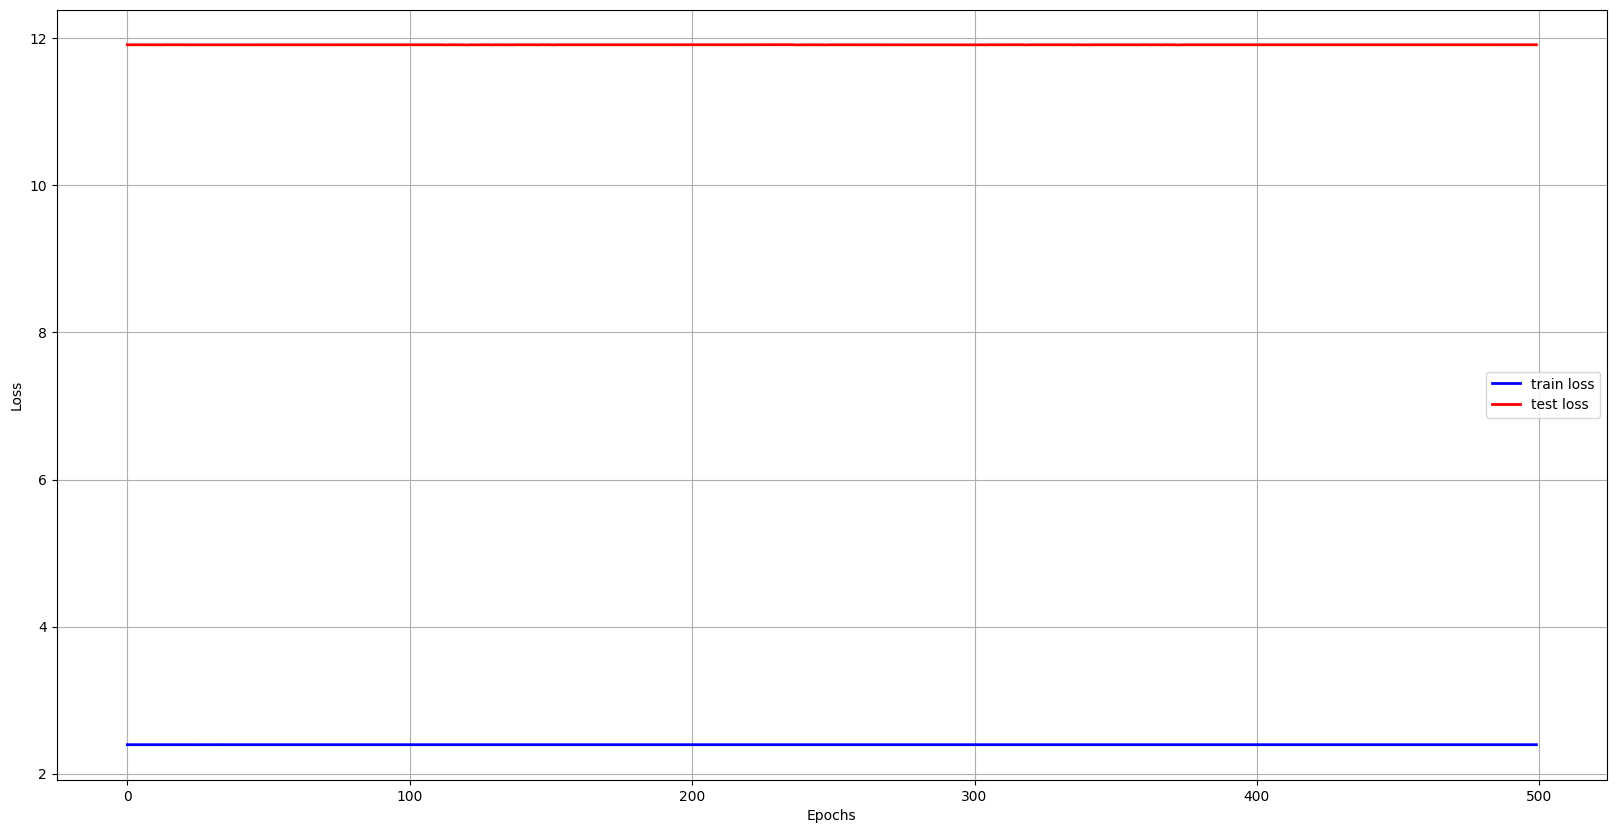

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, label='train loss', color='blue', linewidth=2)
plt.plot(val_loss, label='test loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [24]:
model.eval()

Model(
  (in_fc): Linear(in_features=5, out_features=64, bias=True)
  (hidden_1): Linear(in_features=64, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (out_fc): Linear(in_features=64, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [25]:
eval_prediction_list = []

for idx, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    y = y.to(device)
    
    prediction = model(x)
    eval_prediction_list.append(prediction)

y_pred = torch.cat(eval_prediction_list, dim=0)
y_pred = y_pred.detach().cpu().numpy()

In [26]:
print(f"""y_pred Shape: {y_pred.shape}
y_test Shape: {y_test.shape}""")

y_pred Shape: (176, 11)
y_test Shape: (176, 11)


In [27]:
mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

MSE Loss:  0.1446281


In [28]:
y_test_arg = np.argmax(y_test, axis=1)
y_pred_arg = np.argmax(y_pred, axis=1)
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        11
          10       0.20      1.00      0.34        36

    accuracy                           0.20       176
   macro avg       0.02      0.09      0.03       176
weighted avg       0.04      0.20      0.07       176



/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


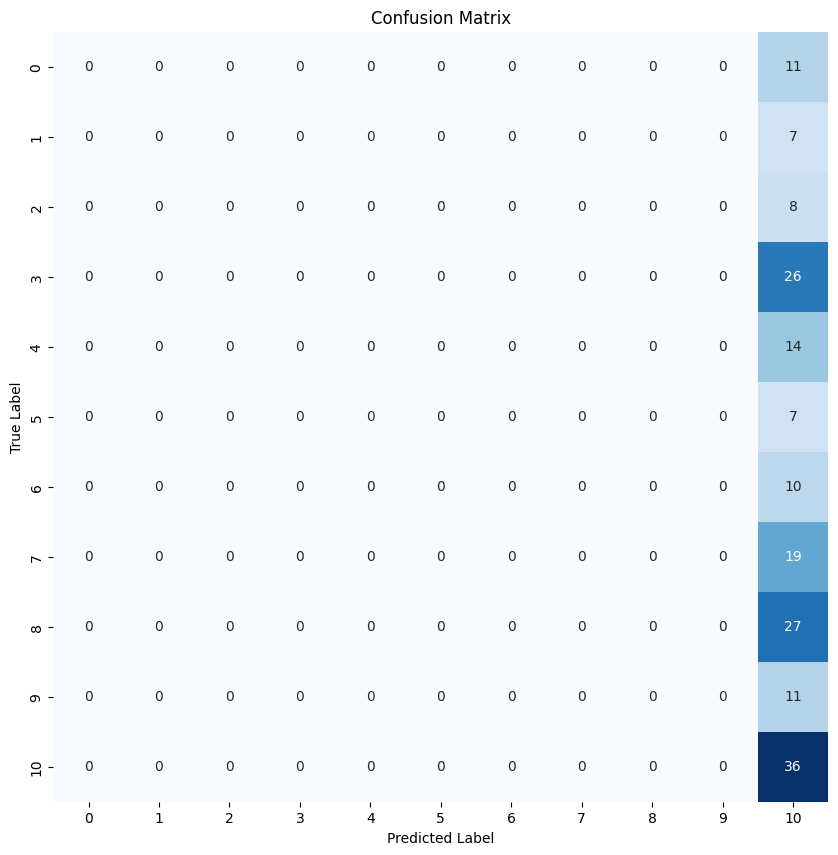

In [29]:
conf_mat = confusion_matrix(y_test_arg, y_pred_arg)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()